In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from scipy import optimize
from autograd import grad

In [17]:
## Neuron parameters
tau = 10.
eta_0 = 0.1
tau_adapt = 10.
v = 0
delta_u = 1.
mu_M = 1e-5
mu_Q = 1e-6
tau_G = 10.
tau_baseline = 100.
dt = 1.
stair_firing_rate = 0.7
nonstair_firing_rate = 0.001

In [18]:
def get_phi_or_eta_update(data, phi_or_eta, curr_time, timescale, time_constant):
    
    return timescale * (1 / time_constant) * (data[:, curr_time - 1] - phi_or_eta[:, curr_time - 1])

def update_phi_or_eta(phi_or_eta, curr_time, update_val):
    
    return phi_or_eta[:, curr_time - 1] + update_val

def update_potential(u_, weight_matrix, phi_, eta_, curr_time):
    
    return np.matmul(weight_matrix, phi_[:, curr_time]) - eta_0 * eta_[:, curr_time]

def get_spike_probs(u_, curr_time):

    return 1 - np.exp(-dt * u_[:, curr_time])

def draw_spikes(spike_probs_, curr_time):
    
    # draw bernoulli spikes
    return np.random.binomial(n = 1, p = spike_probs_[:, curr_time])

In [19]:
## NETWORK PARAMTERS
num_visible = 30
num_hidden = 50
num_neurons = num_visible + num_hidden
num_timebins = 1000

In [20]:
## INITIALIZE WEIGHTS
weights_M = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights_M[:num_visible, :num_visible], 0) # no self-connections for visible neurons

weights_Q = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))

# no connections from visible->visible or hidden->visible in Q weights (top half of matrix)
weights_Q[:num_visible, :] = 0

In [21]:
# INITIALIZE NETWORK RUN
phi = np.zeros(shape = (num_neurons, num_timebins))
eta = np.zeros(shape = (num_neurons, num_timebins))
u = np.zeros(shape = (num_neurons, num_timebins))
spikes = np.zeros(shape = (num_neurons, num_timebins))
spike_probs = np.zeros(shape = (num_neurons, num_timebins))

# phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
phi[:, 0] = np.zeros(num_neurons)
# eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
eta[:, 0] = np.zeros(num_neurons)
u[:, 0] = np.matmul(weights_M, phi[:, 0]) - eta[:, 0]
# spike_probs[:, 0] = sigmoid(u[:, 0])
spike_probs[:, 0] = get_spike_probs(np.exp(u), 0)
spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])

In [22]:
## GENERATE STAIRCASE PATTERN

def get_staircase(num_timebins, num_neurons_, num_visible_, weight_matrix, stair_fr=0.7, nonstair_fr=0.001, num_blocks=3):
    # INITIALIZE NETWORK RUN
    phi = np.zeros(shape = (num_neurons_, num_timebins))
    eta = np.zeros(shape = (num_neurons_, num_timebins))
    u = np.zeros(shape = (num_neurons_, num_timebins))
    rho = np.zeros(shape = (num_neurons_, num_timebins))
    spikes = np.zeros(shape = (num_neurons_, num_timebins))
    spike_probs = np.zeros(shape = (num_neurons_, num_timebins))

    phi[:, 0] = np.zeros(num_neurons_)
    eta[:, 0] = np.zeros(num_neurons_)
    u[:, 0] = np.matmul(weight_matrix, phi[:, 0]) - eta[:, 0]
    rho[:, 0] = np.exp(u[:, 0])
#     spike_probs[:, 0] = get_spike_probs(u[:, 0])
    spike_probs[:, 0] = get_spike_probs(rho, 0)
    spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])

    neuron_block_size = np.floor(num_visible_ * 1.0 / num_blocks)
    curr_neuron_block = np.random.choice(np.arange(num_blocks))
    interval_idx = 0
    timebin_counter = 0

    # intervals for length of "stairs"
    gaussian_intervals = np.random.normal(size = 10000, loc=30, scale=2).astype(int)
    gaussian_intervals[gaussian_intervals <= 0] = 1

    spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

    # simulate network
    for tt in range(1, num_timebins):

        # changes in potential
        dphi = get_phi_or_eta_update(data=spikes, phi_or_eta=phi, curr_time=tt, time_constant=tau, timescale=dt)
        deta = get_phi_or_eta_update(data=spikes, phi_or_eta=eta, curr_time=tt, time_constant=tau_adapt, timescale=dt)
        
        phi[:, tt] = update_phi_or_eta(phi_or_eta=phi, update_val=dphi, curr_time=tt)
        eta[:, tt] = update_phi_or_eta(phi_or_eta=eta, update_val=deta, curr_time=tt)

#         phi[:, tt] = phi[:, tt - 1] + dphi
#         eta[:, tt] = eta[:, tt - 1] + deta

        u[:, tt] = update_potential(u, weight_matrix, phi, eta, tt)
    
        rho[:, tt] = np.exp(u[:, tt])

#         total_potential = np.matmul(weight_matrix, phi[:, tt]) - eta_0 * eta[:, tt]
#         u[:, tt] = total_potential

        spike_probs[:, tt] = get_spike_probs(rho, tt)

#         spike_probs[:, tt] = 1 / (1 + np.exp(-u[:, tt]))
    
        # stair firing rates are fixed
        nonblock_idx = np.delete(np.arange(num_visible), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
        spike_probs[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] = stair_fr
        spike_probs[nonblock_idx, tt] = nonstair_fr
        
        spikes[:, tt] = draw_spikes(spike_probs, tt)
    
        # draw bernoulli spikes
#         spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

        # which neurons are the new stairs?
        timebin_counter += 1
        if timebin_counter == gaussian_intervals[interval_idx]:
            interval_idx += 1
            timebin_counter = 0
            if curr_neuron_block < 2:
                curr_neuron_block += 1
            else:
                curr_neuron_block = 0
                
    return spikes, phi, eta, u, spike_probs

In [23]:
spikes, phi, eta, u, spike_probs = get_staircase(num_timebins=1000, 
                                                      num_neurons_=num_neurons, 
                                                      num_visible_=num_visible, 
                                                      weight_matrix=weights_M,
                                                      stair_fr=stair_firing_rate, 
                                                      nonstair_fr=nonstair_firing_rate)

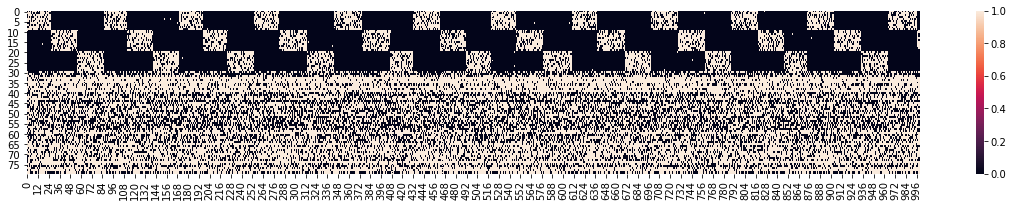

In [24]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes)

In [25]:
## FUNCTIONS FOR M AND Q LIKELIHOODS AND THEIR GRADIENTS

import autograd.numpy as np
rho_0 = 1

def bernoulli_likelihood(data, p_pred, timescale):
    individual_likelihoods = np.multiply(data, np.log(p_pred)) * timescale + np.multiply((1 - data), np.log(1 - p_pred)) * timescale
    return individual_likelihoods

def poisson_likelihood(data, lambda_pred, timescale):
    individual_likelihoods = (np.multiply(np.log(lambda_pred), data) - lambda_pred) * timescale
    return individual_likelihoods

## Likelihood of M network
# def LL_M(curr_weights):
#     # make sure weights are shaped correctly
#     curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

#     total_potential = np.matmul(curr_weights, phi) - eta_0 * eta
    
#     p_pred = get_spike_probs(total_potential)
    
#     individual_likelihoods = bernoulli_likelihood(spikes, p_pred, dt)
#     LL = np.sum(individual_likelihoods)
#     return LL

# ## Likelihood of Q network
# def LL_Q(curr_weights):
#     # make sure weights are shaped correctly
#     curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

#     total_potential = np.matmul(curr_weights, phi_Q) - eta_0 * eta_Q

#     p_pred = sigmoid(total_potential)

#     individual_likelihoods = bernoulli_likelihood(spikes_Q, p_pred, dt)
#     LL = np.sum(individual_likelihoods[num_visible:, :]) # (only sums over hidden neurons)
#     return LL

def LL_M(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta
    
    p_pred = np.exp(total_potential)
    
    individual_likelihoods = poisson_likelihood(spikes, p_pred, dt)
    LL = np.sum(individual_likelihoods)
    return LL

## Likelihood of Q network
def LL_Q(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi_Q) - eta_0 * eta_Q

    p_pred = np.exp(total_potential)

    individual_likelihoods = poisson_likelihood(spikes_Q, p_pred, dt)
    LL = np.sum(individual_likelihoods[num_visible:, :]) # (only sums over hidden neurons)
    return LL

# M gradient by hand
def LL_M_gradient_by_hand(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    curr_rho[num_visible:, :] = rho_Q[num_visible:, :].copy() # set hidden rho to the values determined by Q network
    phi[num_visible:, :] = phi_Q[num_visible:, :].copy() 
    
    spike_intensity_diff = spikes - curr_rho
    M_grad = np.matmul(spike_intensity_diff, phi.T) * dt
    return M_grad

def LL_Q_gradient_by_hand(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi_Q) - eta_0 * eta_Q

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    spike_intensity_diff = spikes_Q - curr_rho
    Q_grad = np.matmul(spike_intensity_diff, phi_Q.T) * dt
    return Q_grad



In [26]:
# GRADIENTS COURTESY OF AUTOGRAD
grad_LL_M = grad(LL_M)
grad_LL_Q = grad(LL_Q)

In [27]:
# INITIALIZE WEIGHTS FOR LEARNING
learned_weights_M = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(learned_weights_M, 0)

learned_weights_Q = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(learned_weights_Q, 0)

# VALUES TO STORE OVER TRAINING
free_energy_trace = []
mean_subtract_free_energy_trace = []
LL_M_trace = []
LL_Q_trace = []

In [28]:
def heatmap_weights(weights_m, weights_q):
    f = plt.figure(figsize=(10, 3))
    f.add_subplot(121)
    plt.title("M weights")
    sns.heatmap(weights_m)
    f.add_subplot(122)
    sns.heatmap(weights_q)
    plt.title("Q weights")
    plt.show()

In [29]:
def simulate_q_network(num_timebins_):

    ## Simulate Q network to get expected likelihood under the current Q weights
    phi_Q = phi.copy()
    eta_Q = eta.copy()
    u_Q = u.copy()
    spikes_Q = np.zeros(shape=(num_neurons, num_timebins))
    rho_Q = np.zeros(shape=(num_neurons, num_timebins))
    spike_probs_Q = np.zeros(shape=(num_neurons, num_timebins))
    spike_probs_Q[:, 0] = get_spike_probs(u_Q, 0)
    spikes_Q[:, 0] = 0 #np.random.binomial(n = 1, p = spike_probs_Q[:, 0])
    spikes_Q[:num_visible, :] = spikes[:num_visible, :].copy()

    ## SIMULATE Q FOR 1,...,T TO GET HIDDEN NEURONS' SPIKES
    for tt in range(1, num_timebins_):

        dphi = get_phi_or_eta_update(data=spikes_Q[num_visible:, :], phi_or_eta=phi_Q[num_visible:, :], curr_time=tt, time_constant=tau, timescale=dt)
        deta = get_phi_or_eta_update(data=spikes_Q[num_visible:, :], phi_or_eta=eta_Q[num_visible:, :], curr_time=tt, time_constant=tau_adapt, timescale=dt)

        phi_Q[num_visible:, tt] = update_phi_or_eta(phi_or_eta=phi_Q[num_visible:, :], update_val=dphi, curr_time=tt)
        eta_Q[num_visible:, tt] = update_phi_or_eta(phi_or_eta=eta_Q[num_visible:, :], update_val=deta, curr_time=tt)

        u_Q[num_visible:, tt] = update_potential(u_Q[num_visible:, :], learned_weights_Q[num_visible:, :], phi_Q, eta_Q[num_visible:, :], tt)

        rho_Q[num_visible:, tt] = np.exp(u_Q[num_visible:, tt])

        spike_probs_Q[num_visible:, tt] = get_spike_probs(rho_Q[num_visible:, :], tt)

        spikes_Q[num_visible:, tt] = draw_spikes(spike_probs_=spike_probs_Q[num_visible:, :], curr_time=tt)
        
    return spikes_Q, spike_probs_Q, u_Q, eta_Q, phi_Q, rho_Q

iter: 0, M: -86994.1874587, Q: -48987.7299082


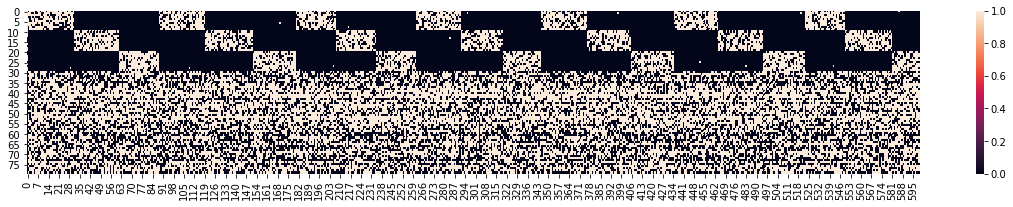

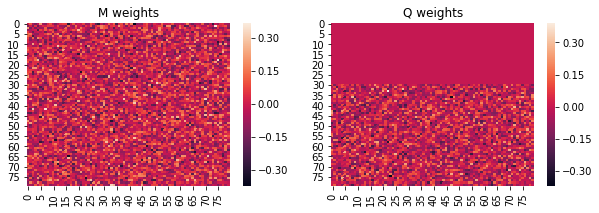

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in subtract
  # This is added back by InteractiveShellApp.init_path()


KeyboardInterrupt: 

In [30]:
## TRAINING
num_timebins = 1000
num_total_timebins = 100000
print_iter = 50

# LEARNING PARAMETERS
num_iters = 3000
variance_reduction_window = 3 # window of past free energies to average and subtract (reduces gradient variance)

for iter_num in range(num_iters):

    # get a sample from the staircase pattern
    spikes, phi, eta, u, spike_probs = get_staircase(num_timebins, 
                                                      num_neurons_=num_neurons, 
                                                      num_visible_=num_visible, 
                                                      weight_matrix=learned_weights_M,
                                                      stair_fr=stair_firing_rate, 
                                                      nonstair_fr=nonstair_firing_rate)
    
    spikes_Q, spike_probs_Q, u_Q, eta_Q, phi_Q, rho_Q = simulate_q_network(num_timebins)

    # Set hidden neuron activity to be those just simulated from Q network
    spikes[num_visible:, :] = spikes_Q[num_visible:, :].copy()
    phi[num_visible:, :] = phi_Q[num_visible:, :].copy()
    eta[num_visible:, :] = eta_Q[num_visible:, :].copy()
    u[num_visible:, :] = u_Q[num_visible:, :].copy()
    spike_probs[num_visible:, :] = spike_probs_Q[num_visible:, :].copy()
    
    if iter_num % print_iter == 0:
        fig, ax = plt.subplots(figsize=(20, 3))
        sns.heatmap(spikes_Q[:, :600])
    
    # M likelihood
    curr_LL_M = LL_M(learned_weights_M)
    LL_M_trace.append(curr_LL_M)
    
    # M gradient
#     M_weights_gradients = grad_LL_M(learned_weights_M)
    M_weights_gradients = LL_M_gradient_by_hand(learned_weights_M)
    
    # update M weights
    learned_weights_M += mu_M * M_weights_gradients
    np.fill_diagonal(learned_weights_M[:num_visible, :num_visible], 0)

    # Q likelihood
    curr_LL_Q = LL_Q(learned_weights_Q)
    LL_Q_trace.append(curr_LL_Q)
    
    # Q gradient
#     Q_weights_gradients = grad_LL_Q(learned_weights_Q)
    Q_weights_gradients = LL_Q_gradient_by_hand(learned_weights_Q)
    
    # Calculate point estimate of free energy
    free_energy = curr_LL_Q - curr_LL_M
    free_energy_trace.append(free_energy)

    # Variance reduction technique from paper (mean-subtract free energy)
    if iter_num == 0:
        curr_free_energy = 1
    else:
        curr_window_start_idx = max(-variance_reduction_window, -len(free_energy_trace))
        curr_free_energy = free_energy - np.mean(free_energy_trace[curr_window_start_idx:])
        mean_subtract_free_energy_trace.append(curr_free_energy)

    # update Q weights
    learned_weights_Q -= mu_Q * Q_weights_gradients * curr_free_energy

    # reset connections to visible to 0
    learned_weights_Q[:num_visible, :] = 0
    
    # print progress
    if iter_num % print_iter == 0:
        print 'iter: {}, M: {}, Q: {}'.format(iter_num, curr_LL_M, curr_LL_Q)
        
        ## HEATMAP LEARNED WEIGHTS
        heatmap_weights(learned_weights_M, learned_weights_Q)
        
#         m_spikes_sim = simulate_m_network()
#         fig, ax = plt.subplots(figsize=(20, 3))
#         sns.heatmap(m_spikes_sim)



In [ ]:
plt.plot(mean_subtract_free_energy_trace)

In [ ]:
## PLOT LOSS OVER TIME
fig, ax1 = plt.subplots(figsize = (10, 5))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('M -LL', color=color)
ax1.plot(LL_M_trace, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Q -LL', color=color)  # we already handled the x-label with ax1
ax2.plot(LL_Q_trace, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
## HEATMAP LEARNED WEIGHTS
heatmap_weights(learned_weights_M, learned_weights_Q)

In [ ]:
## SIMULATE LEARNED M NETWORK


num_simulated_timebins = 1000
phi_sim = np.zeros(shape=(num_neurons, num_simulated_timebins))
eta_sim = np.zeros(shape =(num_neurons, num_simulated_timebins))
u_sim = np.zeros(shape =(num_neurons, num_simulated_timebins))
spikes_sim = np.zeros(shape =(num_neurons, num_simulated_timebins))
spike_probs_sim = np.zeros(shape=(num_neurons, num_simulated_timebins))

# heat up network with a staircase before simulating
spikes, phi, eta, u, spike_probs = get_staircase(200, 
                                                      num_neurons_=num_neurons, 
                                                      num_visible_=num_visible, 
                                                      weight_matrix=learned_weights_M,
                                                      stair_fr=stair_firing_rate, 
                                                      nonstair_fr=nonstair_firing_rate)

phi_sim[:, :num_timebins] = phi.copy()
eta_sim[:, :num_timebins] = eta.copy()
spikes_sim[:, :num_timebins] = spikes.copy()
u_sim[:, :num_timebins] = u.copy()

for tt in range(1, 1000):

    dphi = get_phi_or_eta_update(data=spikes_sim, phi_or_eta=phi_sim, curr_time=tt, time_constant=tau, timescale=dt)
    deta = get_phi_or_eta_update(data=spikes_sim, phi_or_eta=eta_sim, curr_time=tt, time_constant=tau_adapt, timescale=dt)

    phi_sim[:, tt] = phi_sim[:, tt - 1] + dphi
    eta_sim[:, tt] = eta_sim[:, tt - 1] + deta

    total_potential = np.matmul(learned_weights_M, phi_sim[:, tt]) - eta_0 * eta_sim[:, tt]
    u_sim[:, tt] = total_potential 

    spike_probs_sim[:, tt] = 1 / (1 + np.exp(-u_sim[:, tt]))

    # during "heat up" period, only simulate hidden neuron spikes
    if tt <= 90:
        spikes_sim[num_visible:, tt] = np.random.binomial(n = 1, p = spike_probs_sim[num_visible:, tt])
    else:
        spikes_sim[:, tt] = np.random.binomial(n = 1, p = spike_probs_sim[:, tt])

In [ ]:
## HEATMAP SIMULATED M NETWORK

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes_sim[:, :600])
plt.ylabel("Neuron")
plt.title("Spikes")
plt.savefig("./plots/m_network_simulated_spikes.png", bbox_inches='tight')
plt.show()

In [ ]:
# Simulate Q network (inference mode)
spikes_sim_Q, phi_sim_Q, eta_sim_Q, u_sim_Q, spike_probs_sim_Q = get_staircase(num_timebins=1000, 
                                                      num_neurons_=num_neurons, 
                                                      num_visible_=num_visible, 
                                                      weight_matrix=learned_weights_Q,
                                                      stair_fr=stair_firing_rate, 
                                                      nonstair_fr=nonstair_firing_rate)

In [ ]:
## HEATMAP SIMULATED Q NETWORK
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes_sim_Q[:, :600])
plt.ylabel("Neuron")
plt.title("Spikes")
plt.show()